In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import probscale
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [134]:
order_df = pd.read_csv("order_items.csv")
df_test = pd.read_csv("test_trips.csv")
df_train = pd.read_csv("train_trips.csv")

In [135]:
df_train.columns

Index(['trip_id', 'shopper_id', 'fulfillment_model', 'store_id',
       'shopping_started_at', 'shopping_ended_at'],
      dtype='object')

In [136]:
order_df.columns

Index(['trip_id', 'item_id', 'department_name', 'quantity'], dtype='object')

# 1. Data Cleaning
We need to find the Shopping time which is difference between shopping_ended_at and shopping_started_at.
Extracting Shopping time....

In [137]:
#First, convert datetime strings into datetime

df_train["shopping_started_at"] = pd.to_datetime(df_train["shopping_started_at"], format='%Y-%m-%d %H:%M:%S')
df_train["shopping_ended_at"] = pd.to_datetime(df_train["shopping_ended_at"], format='%Y-%m-%d %H:%M:%S')

df_train['shopping_time'] = pd.to_datetime(df_train['shopping_ended_at'])  - pd.to_datetime(df_train['shopping_started_at']) 

#Convert duration to seconds for easier interpretation

df_train['shopping_time'] = pd.to_timedelta(df_train["shopping_time"]).astype('timedelta64[s]').astype(int)

In [138]:
# df_train.head(5)

### Convert categorical variables to numeric 

In [139]:
# df_train['fulfillment_model'].value_counts()

In [140]:
df_train['fulfillment_model'] = df_train['fulfillment_model'].map({'model_2':2,'model_1':1})

In [141]:
# df_train['fulfillment_model'].value_counts()

In [142]:
# There a total 14 stores 
#df_train.store_id.value_counts().reset_index().sort_values(by='index')

In [143]:
store_ids = {1:1, 3:2, 5:3, 6:4, 29:5, 31:6, 54:7, 78:8, 90:9, 105:10, 115:11, 123:12, 126:13, 148:14}

#Convert random store ids variables to sequential store id's
df_train['store_id'] = df_train['store_id'].map(store_ids)

## Extracting Features from Order details ...
1. total_quantity per trip id, 
2. departmentwise quantity per trip id, 
3. num distict items per trip id,
4. number of distinct departments per trip id

In [144]:
##1. One trip id is having multiple order from multiple deparments . we can have total quantity as one of the feature

total_quantity_trip = order_df.groupby(by=['trip_id'])["quantity"].sum()

# to Convert pd.series into data frame and then inner join to get total quantity for a trip
total_quantity_trip = total_quantity_trip.to_frame().reset_index()

total_quantity_trip.rename(columns={"quantity": "total_quantity"}, inplace=True)
# total_quantity_trip.head()

In [145]:
##2. Departmentwise quantity per trip id, 
order_quantity_by_department = order_df.groupby(by=['trip_id','department_name'])["quantity"].sum()
order_quantity_by_department = order_quantity_by_department.to_frame().reset_index()


orders_pivot = order_quantity_by_department.pivot_table(index='trip_id',columns='department_name',values='quantity')

orders_pivot.to_csv('orders_pivot.csv') 

In [146]:
##3. Distinct items per trip id 

num_distinct_items_trip = order_df.groupby(by=['trip_id'])["item_id"].nunique()

# to Convert pd.series into data frame and then inner join to get total quantity for a trip
num_distinct_items_trip = num_distinct_items_trip.to_frame().reset_index()

num_distinct_items_trip.rename(columns={"item_id": "distinct_items"}, inplace=True)

# num_distinct_items_trip.head()

In [147]:
##4. Department wise quantiy per trip id 

num_distinct_department_trip = order_df.groupby(by=['trip_id'])["department_name"].nunique()

# to Convert pd.series into data frame and then inner join to get total quantity for a trip
num_distinct_department_trip = num_distinct_department_trip.to_frame().reset_index()

num_distinct_department_trip.rename(columns={"department_name": "distinct_departments"}, inplace=True)
# num_distinct_department_trip.head()

In [148]:
df_train = pd.merge(df_train, total_quantity_trip,  on = "trip_id",how='inner')
df_train = pd.merge(df_train, num_distinct_items_trip,  on = "trip_id",how='inner')
df_train = pd.merge(df_train, num_distinct_department_trip,  on = "trip_id",how='inner')

In [128]:
df_test = pd.merge(df_test, total_quantity_trip,  on = "trip_id",how='inner')
df_test = pd.merge(df_test, num_distinct_items_trip,  on = "trip_id",how='inner')
df_test = pd.merge(df_test, num_distinct_department_trip,  on = "trip_id",how='inner')


In [132]:
df_test.head(5)

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at,total_quantity,distinct_items,distinct_departments
0,4310899,60930,model_2,123,2015-11-16 07:00:12,28.0,16,9
1,4310904,59815,model_2,123,2015-11-16 07:00:12,48.0,39,15
2,4310907,60878,model_2,123,2015-11-16 07:00:13,21.0,18,8
3,4310911,60879,model_2,123,2015-11-16 07:00:13,8.0,4,4
4,4310328,66726,model_1,1,2015-11-16 07:01:08,14.0,14,8


In [149]:
df_train.shape

(117063, 10)

In [111]:
df_train_test.columns

Index(['trip_id', 'shopper_id', 'fulfillment_model', 'store_id',
       'shopping_started_at', 'total_quantity'],
      dtype='object')

In [16]:
orders = pd.read_csv('orders_pivot.csv')
orders = orders.fillna(0)




df_train = pd.merge(df_train, orders,  on = "trip_id",how='inner')

# df_train.head(5)

In [150]:
#Now construct other variables, like month, date, etc.

df_train["start_month"] = df_train["shopping_started_at"].dt.month
df_train["start_day"] = df_train["shopping_started_at"].dt.day
df_train["start_weekday"] = df_train["shopping_started_at"].dt.weekday 
df_train["start_hour"] = df_train["shopping_started_at"].dt.hour
df_train["start_minute"] = df_train["shopping_started_at"].dt.minute

In [151]:
df1 = df_train[df_train['trip_id'] == 3119519]
df1

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at,shopping_ended_at,shopping_time,total_quantity,distinct_items,distinct_departments,start_month,start_day,start_weekday,start_hour,start_minute
0,3119519,48539,1,4,2015-09-01 07:03:56,2015-09-01 07:30:56,1620,39.0,26,11,9,1,1,7,3


In [152]:
df_train.shape

(117063, 15)

# 2. EDA 

### Distribution of Shipping Time and measure of skewness/Kurtosis

120 10740
No cases with shopping time more than 6000 secs: 2962
% cases with shopping time more than 6000 secs : 2.530261483133014
(117063, 15)
(114101, 15)


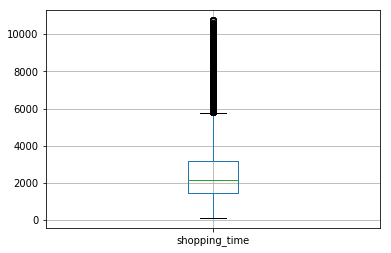

In [153]:
# Getting the variables ready for modelling - Initiall Data Analysis (IDA)
import matplotlib.pyplot as plt
plt.show()
# Looking closely at Dependent Variable - shopping_time

print (df_train['shopping_time'].min(),df_train['shopping_time'].max())

# Consideration 1 - We see that there are some cases with delivery time > 6000 looking at these oultiers below 
df_train.boxplot(column = 'shopping_time')


print ("No cases with shopping time more than 6000 secs: {}".format(len(df_train[df_train['shopping_time']>6000])))

print ("% cases with shopping time more than 6000 secs : {}".format((len(df_train[df_train['shopping_time']>6000])/len(df_train))*100))

print(df_train.shape)

# Removing these cases from the dataset as its fair to assume that these are data log issues as a delivery time cannot be greater
# than 8000 secs.

df_train = df_train[df_train['shopping_time']<=6000]

print(df_train.shape)

In [154]:
df_train['shopping_time'].describe()

count    114101.000000
mean       2333.170787
std        1208.980500
min         120.000000
25%        1440.000000
50%        2100.000000
75%        3060.000000
max        6000.000000
Name: shopping_time, dtype: float64

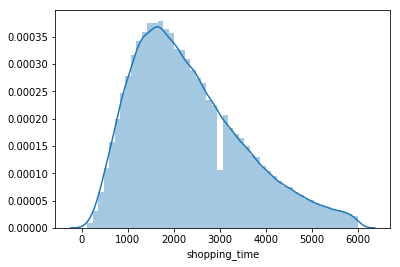

In [155]:
#histogram
sns.distplot(df_train['shopping_time']);

In [156]:
#skewness and kurtosis
print("Skewness: %f" % df_train['shopping_time'].skew())
print("Kurtosis: %f" % df_train['shopping_time'].kurt())

Skewness: 0.733177
Kurtosis: 0.024150


####  data sets with high kurtosis tend to have heavy tails, or outliers and the skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. The data is moderately skewed

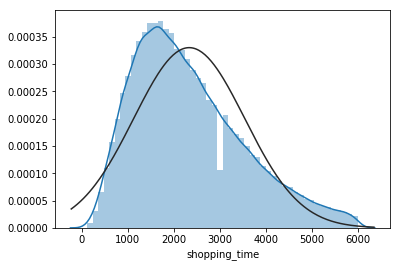

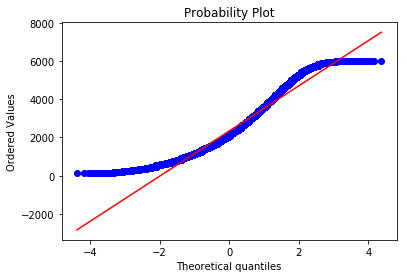

In [157]:
#histogram and normal probability plot
sns.distplot(df_train['shopping_time'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['shopping_time'], plot=plt)

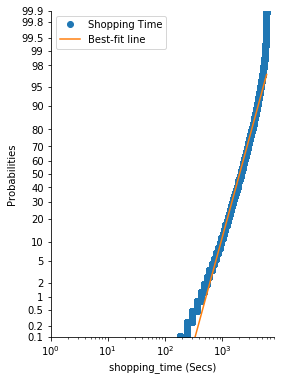

In [158]:
fig, ax = plt.subplots(figsize=(4, 6))
fig = probscale.probplot(df_train['shopping_time'], ax=ax, plottype='prob', probax='y', bestfit=True,
                         datascale='log', problabel='Probabilities', datalabel='shopping_time (Secs)',
                         scatter_kws=dict(label='Shopping Time'),
                         line_kws=dict(label='Best-fit line'))
ax.legend(loc='upper left')
ax.set_ylim(bottom=0.1, top=99.9)
ax.set_xlim(left=1, right=8000)
sns.despine()

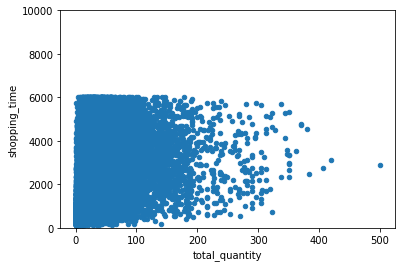

In [159]:
#scatter plot quantity/shippingtime
var = 'total_quantity'
data = pd.concat([df_train['shopping_time'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='shopping_time', ylim=(0,10000));

### Relationship with categorical features

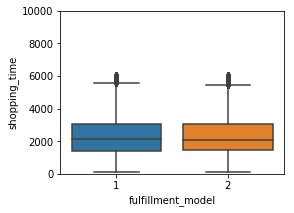

In [160]:
#box plot model/shipping time
var = 'fulfillment_model'
data = pd.concat([df_train['shopping_time'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(4, 3))
fig = sns.boxplot(x=var, y="shopping_time", data=data)
fig.axis(ymin=0, ymax=10000);

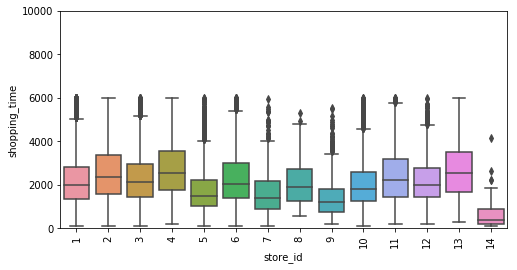

In [161]:
var = 'store_id'
data = pd.concat([df_train['shopping_time'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x=var, y="shopping_time", data=data)
fig.axis(ymin=0, ymax=10000);
plt.xticks(rotation=90);

###### store_ids = {1:1, 3:2, 5:3, 6:4, 29:5, 31:6, 54:7, 78:8, 90:9, 105:10, 115:11, 123:12, 126:13, 148:14}


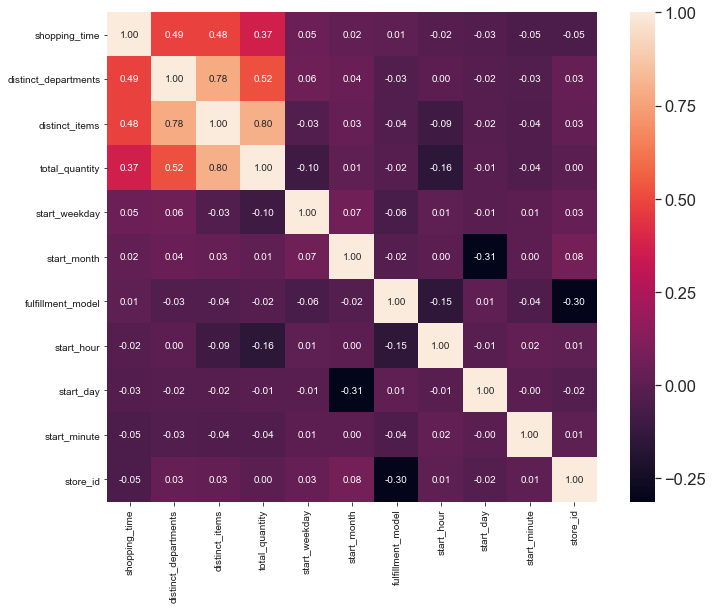

In [162]:
# Removing id's and timestamp (converted it to day/hour/min)
df_train_corr = df_train.drop(["trip_id", "shopper_id", "shopping_started_at", "shopping_ended_at"], axis=1)


#correlation matrix

corrmat = df_train_corr.corr()
f, ax = plt.subplots(figsize=(12, 9))
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'shopping_time')['shopping_time'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.50)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Missing Values

In [163]:
# missing data in the training 
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)

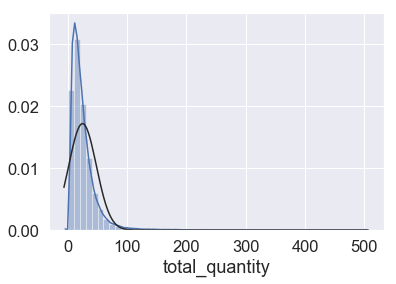

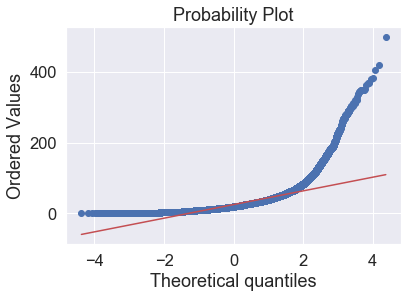

In [164]:
#histogram and normal probability plot
sns.distplot(df_train['total_quantity'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['total_quantity'], plot=plt)

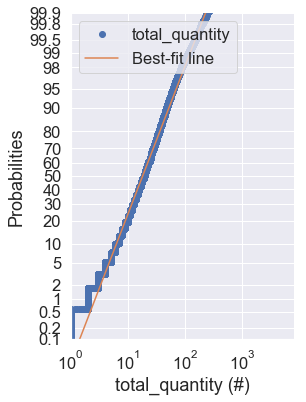

In [165]:
fig, ax = plt.subplots(figsize=(4, 6))
fig = probscale.probplot(df_train['total_quantity'] , ax=ax, plottype='prob', probax='y', bestfit=True,
                         datascale='log', problabel='Probabilities', datalabel='total_quantity (#)',
                         scatter_kws=dict(label='total_quantity'),
                         line_kws=dict(label='Best-fit line'))
ax.legend(loc='upper left')
ax.set_ylim(bottom=0.1, top=99.9)
ax.set_xlim(left=1, right=8000)
sns.despine()

# 2. Modeling 

In [166]:
X = np.log1p(df_train.drop(["shopping_time","trip_id", "shopper_id", "shopping_started_at", "shopping_ended_at"], axis=1))
y = np.log1p(df_train["shopping_time"])

# X.head(5)

In [167]:
#  Data Preperocessing before modelling

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [168]:
# Scaling the X variables for train set
sc = preprocessing.StandardScaler().fit(X_train) #sc.mean_, sc.scale_
X_train = sc.transform(X_train)

In [169]:

# df_train.shape
from sklearn.model_selection import train_test_split
#Split the data into training, test, and valdiation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [170]:
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
Y_pred = regr.predict(X_test)

mean_squared_error(y_true=y_test, y_pred=Y_pred)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, Y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, Y_pred))

Mean squared error: 0.22
Variance score: 0.33


In [171]:
from sklearn.linear_model import Lasso

best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(X_train, y_train)

# Run prediction on training set to get a rough idea of how well it does.
y_pred_lasso = regr.predict(X_test)

print("Lasso score on training set: ", rmse(y_test, y_pred_lasso))

# Run prediction on the test set.
y_pred_lasso = regr.predict(X_test)
print('Lasso Variance score: %.2f' % r2_score(y_test, y_pred_lasso))

Lasso score on training set:  0.46843626997408694
Lasso Variance score: 0.33


In [172]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test,Y_pred)

0.32804753816232346

In [173]:
# The error metric: RMSE on the log of the shopping time
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
import xgboost as xgb
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)
regr.fit(X_train, y_train)

# Run prediction on training set to get a rough idea of how well it does.
Y_pred = regr.predict(X_test)
print("XGBoost score on training set: ", rmse(y_test, Y_pred))

In [65]:
X_train.head(5)

,fulfillment_model,store_id,total_quantity,distinct_items,distinct_departments,25% OFF Supplements 8/14-8/16,4th of July,Academy Awards,Alcohol,All It Takes to Bake!,...,Thanksgiving Menu,Travel,Valentine's Day Specials,Valentine's- Made with Love!,Vitamins & Supplements,start_month,start_day,start_weekday,start_hour,start_minute
111458,1.098612,1.098612,3.828641,3.295837,2.302585,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,2.484907,2.564949,1.386294,2.890372,1.945910
110271,1.098612,0.693147,2.302585,2.079442,1.386294,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,2.484907,2.484907,1.098612,2.995732,3.332205
985,1.098612,0.693147,3.401197,2.772589,1.791759,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,2.302585,0.693147,0.693147,2.833213,1.098612
106052,0.693147,1.609438,3.218876,2.564949,2.197225,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,2.484907,2.302585,0.000000,2.708050,3.988984
66747,1.098612,1.098612,4.276666,3.688879,2.772589,0.0,0.0,0.0,1.386294,0.0,...,0.0,0.0,0.0,0.0,0.0,2.397895,2.772589,1.386294,2.564949,3.784190


In [50]:
# Run prediction on the test set.
y_pred_xgb = regr.predict(X_test)

print('XGBoost Variance score: %.2f' % r2_score(y_test, y_pred_xgb))

XGBoost Variance score: 0.41


In [51]:
# XGBoost gave the best performance
df_test.head(5)

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at
0,4310899,60930,model_2,123,2015-11-16 07:00:12
1,4310904,59815,model_2,123,2015-11-16 07:00:12
2,4310907,60878,model_2,123,2015-11-16 07:00:13
3,4310911,60879,model_2,123,2015-11-16 07:00:13
4,4310328,66726,model_1,1,2015-11-16 07:01:08


In [75]:
#Convert random store ids variables to sequential store id's
df_test['store_id'] = df_test['store_id'].map(store_ids)

In [76]:
df_test.shape

(11647, 5)

In [88]:
df_test['fulfillment_model'] = df_test['fulfillment_model'].map({'model_2':2,'model_1':1})

In [55]:
df_test = pd.merge(df_test, total_quantity_trip,  on = "trip_id",how='inner')
df_test = pd.merge(df_test, num_distinct_items_trip,  on = "trip_id",how='inner')
df_test = pd.merge(df_test, num_distinct_department_trip,  on = "trip_id",how='inner')

In [77]:
df_test.shape

(11647, 5)

In [78]:
orders = pd.read_csv('orders_pivot.csv')
orders = orders.fillna(0)
df_test = pd.merge(df_test, orders,  on = "trip_id",how='inner')

df_test.shape

(11647, 91)

In [89]:
X1 = df_test.drop(["trip_id", "shopper_id", "shopping_started_at"], axis=1)

In [90]:
df_train.columns

Index(['trip_id', 'shopper_id', 'fulfillment_model', 'store_id',
       'shopping_started_at', 'shopping_ended_at'],
      dtype='object')

In [91]:
X1.shape

(11647, 88)

In [92]:
# Run prediction on the test set.
y_pred_xgb1 = regr.predict(X1)

# print('XGBoost Variance score: %.2f' % r2_score(y_test, y_pred_xgb))

ValueError: feature_names mismatch: ['fulfillment_model', 'store_id', 'total_quantity', 'distinct_items', 'distinct_departments', '25% OFF Supplements 8/14-8/16', '4th of July', 'Academy Awards', 'Alcohol', 'All It Takes to Bake!', 'Aquatics', 'BBQ Favorites', 'Babies', 'Bakery', 'Beverages', 'Bi-Rite Creamery', "Bi-Rite's Winter Favorites!", 'Bird', 'Breakfast', 'Bulk', 'Burning Man Essentials', 'Business Items', "Buyers' Picks", 'Canned Goods', 'Cat', 'Cheese', 'Christmas & NYE Menu', 'Costumes', 'Dairy & Eggs', 'Deli', 'Dog', 'Dry Goods & Pasta', 'Fall Wine, Beer, & Spirits', "Father's Day", 'Fill the Grill', 'Find it at Target', 'FitMarket', 'Floral', 'Flowers & Plants', 'Fromagerie', 'Frozen', 'Game Day Specials', 'Gifts for the Foodie', 'Halloween', 'Hanukkah', 'Hanukkah Menu', 'Healthy Choices for 2016', 'Healthy Eating', 'Holiday', 'Holiday Butcher', 'Holiday Essentials', 'Holiday Favorites', 'Holiday Turkeys', 'Holidays', 'Household', 'Ice Cream Social!', 'International', 'Local', 'Local Favorites', 'Meat & Seafood', "Mother's Day", "New Year's Eve Extravaganza!", 'Newly Added', 'Olives, Gourmet Cheese, Salads', 'Our Brands', 'Pantry', 'Passover & Easter', 'Personal Care', 'Pets', 'Popular', 'Produce', 'Ready to Cook', 'Ready to Eat', 'Reptile', 'Rosh Hashanah & Yom Kippur', 'Seasonal', 'Small Animal', 'Smoothie Central', 'Snacks', "St. Patrick's Day Specials", 'Star Wars', 'Summer Drinks', 'Super Bowl Party', 'TEST SPECIAL AISLE', 'Thanksgiving', 'Thanksgiving A to Z', 'Thanksgiving Menu', 'Travel', "Valentine's Day Specials", "Valentine's- Made with Love!", 'Vitamins & Supplements', 'start_month', 'start_day', 'start_weekday', 'start_hour', 'start_minute'] ['fulfillment_model', 'store_id', '25% OFF Supplements 8/14-8/16', '4th of July', 'Academy Awards', 'Alcohol', 'All It Takes to Bake!', 'Aquatics', 'BBQ Favorites', 'Babies', 'Bakery', 'Beverages', 'Bi-Rite Creamery', "Bi-Rite's Winter Favorites!", 'Bird', 'Breakfast', 'Bulk', 'Burning Man Essentials', 'Business Items', "Buyers' Picks", 'Canned Goods', 'Cat', 'Cheese', 'Christmas & NYE Menu', 'Costumes', 'Dairy & Eggs', 'Deli', 'Dog', 'Dry Goods & Pasta', 'Fall Wine, Beer, & Spirits', "Father's Day", 'Fill the Grill', 'Find it at Target', 'FitMarket', 'Floral', 'Flowers & Plants', 'Fromagerie', 'Frozen', 'Game Day Specials', 'Gifts for the Foodie', 'Halloween', 'Hanukkah', 'Hanukkah Menu', 'Healthy Choices for 2016', 'Healthy Eating', 'Holiday', 'Holiday Butcher', 'Holiday Essentials', 'Holiday Favorites', 'Holiday Turkeys', 'Holidays', 'Household', 'Ice Cream Social!', 'International', 'Local', 'Local Favorites', 'Meat & Seafood', "Mother's Day", "New Year's Eve Extravaganza!", 'Newly Added', 'Olives, Gourmet Cheese, Salads', 'Our Brands', 'Pantry', 'Passover & Easter', 'Personal Care', 'Pets', 'Popular', 'Produce', 'Ready to Cook', 'Ready to Eat', 'Reptile', 'Rosh Hashanah & Yom Kippur', 'Seasonal', 'Small Animal', 'Smoothie Central', 'Snacks', "St. Patrick's Day Specials", 'Star Wars', 'Summer Drinks', 'Super Bowl Party', 'TEST SPECIAL AISLE', 'Thanksgiving', 'Thanksgiving A to Z', 'Thanksgiving Menu', 'Travel', "Valentine's Day Specials", "Valentine's- Made with Love!", 'Vitamins & Supplements']
expected start_hour, start_month, distinct_items, total_quantity, start_day, distinct_departments, start_minute, start_weekday in input data

In [87]:
X1.head(5)

,fulfillment_model,store_id,25% OFF Supplements 8/14-8/16,4th of July,Academy Awards,Alcohol,All It Takes to Bake!,Aquatics,BBQ Favorites,Babies,...,Summer Drinks,Super Bowl Party,TEST SPECIAL AISLE,Thanksgiving,Thanksgiving A to Z,Thanksgiving Menu,Travel,Valentine's Day Specials,Valentine's- Made with Love!,Vitamins & Supplements
0,model_2,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,model_2,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,model_2,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,model_2,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,model_1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
